### Classifier with w2v vectors

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics  import f1_score,accuracy_score
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.model_selection import cross_validate
from sklearn import svm
import keras
from sklearn.preprocessing import OneHotEncoder
import pickle
import sys

In [2]:
train_set = pd.read_csv("dataset_train_pp.csv")
test_set = pd.read_csv("dataset_test_pp.csv")

In [3]:
print(len(train_set))
print(len(test_set))

50000
5000


In [4]:
train_x=train_set["Description"]
test_x=test_set["Description"]

train_y=train_set["Class Index"]
test_y=test_set["Class Index"]

In [5]:
%%time
test_x_vectors = np.load("w2v_test_x_google.npy")

CPU times: user 5.86 ms, sys: 4.41 ms, total: 10.3 ms
Wall time: 7.59 ms


In [6]:
%%time
train_x_vectors = np.load("w2v_train_x_google.npy")

CPU times: user 4.36 ms, sys: 56.9 ms, total: 61.3 ms
Wall time: 59.4 ms


In [7]:
# plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='confusion_matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j], 
                horizontalalignment='center', 
                color='white' if cm[i,j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Naive Bays

In [8]:
naive_bays = MultinomialNB()

In [9]:
%%time
naive_bays.fit(train_x_vectors, train_y)

CPU times: user 185 ms, sys: 77.1 ms, total: 262 ms
Wall time: 218 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [21]:
p = pickle.dumps(naive_bays)
memoryKB = sys.getsizeof(p)/1000
print(memoryKB)

24.749


In [10]:
%%time
nb_pred_x = naive_bays.predict(test_x_vectors)

CPU times: user 19.1 ms, sys: 8.73 ms, total: 27.8 ms
Wall time: 17.1 ms


In [11]:
accuracy_score(test_y,nb_pred_x)

0.7886

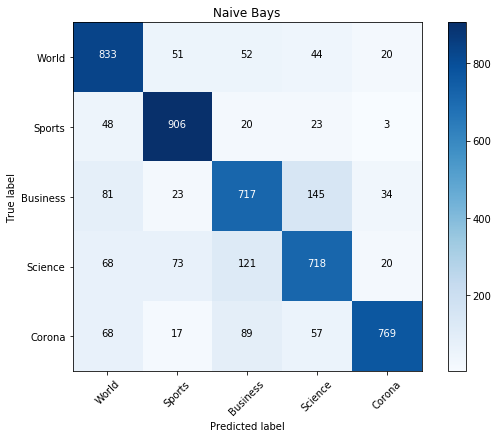

In [12]:
nb_cm = confusion_matrix(test_y, nb_pred_x)
cmPlotLabels = ['World', 'Sports', 'Business', 'Science', 'Corona']
plot_confusion_matrix(nb_cm, cmPlotLabels, title='Naive Bays')

### SVM

In [13]:
svm_model = svm.SVC(kernel='poly', degree=2, gamma='scale')

In [14]:
%%time
svm_model.fit(train_x_vectors, train_y)
# svm_model.fit(test_x_vectors, test_y) for speed test

CPU times: user 13min 33s, sys: 4.43 s, total: 13min 38s
Wall time: 13min 39s


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='scale', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [17]:
p = pickle.dumps(svm_model)
memoryKB = sys.getsizeof(p)/1000
print(memoryKB)

44490.259


In [18]:
%%time
svm_pred_x = svm_model.predict(test_x_vectors)

CPU times: user 57 s, sys: 71.8 ms, total: 57.1 s
Wall time: 57.2 s


In [19]:
accuracy_score(test_y,svm_pred_x)

0.88

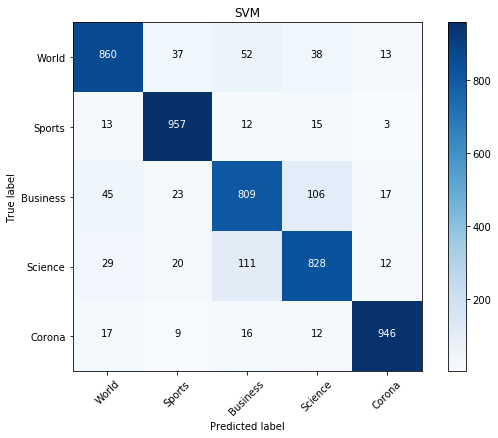

In [20]:
svm_cm = confusion_matrix(test_y, svm_pred_x)
plot_confusion_matrix(svm_cm, cmPlotLabels, title='SVM')

https://stackoverflow.com/questions/10592605/save-classifier-to-disk-in-scikit-learn

### NN

#### Prepare labels for keras

In [22]:
enc = OneHotEncoder(handle_unknown='ignore')

In [23]:
test_y_array = test_y.to_numpy().reshape(-1,1)
train_y_array = train_y.to_numpy().reshape(-1,1)

In [24]:
enc.fit(test_y_array)
test_y_1hot = enc.transform(test_y_array).toarray()

In [25]:
enc.fit(train_y_array)
train_y_1hot = enc.transform(train_y_array).toarray()

#### keras model

In [27]:
nn_model = None
nn_model = keras.models.Sequential()
nn_model.add(keras.layers.Dense(32, input_dim=300, activation='relu'))
nn_model.add(keras.layers.Dense(16, activation='relu'))
nn_model.add(keras.layers.Dense(16, activation='relu'))
nn_model.add(keras.layers.Dense(5, activation='softmax'))

In [28]:
nn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                9632      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 85        
Total params: 10,517
Trainable params: 10,517
Non-trainable params: 0
_________________________________________________________________


In [31]:
nn_model.compile(keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
%%time
nn_model.fit(train_x_vectors, train_y_1hot, epochs=20, batch_size=10)

W0620 18:25:07.041413 140258955380480 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0620 18:25:07.171005 140258955380480 deprecation_wrapper.py:119] From /home/amirhossein/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/20
50000/50000 [==============================] - 17s 336us/step - loss: 0.6103 - acc: 0.7901
Epoch 2/20
50000/50000 [==============================] - 15s 296us/step - loss: 0.4620 - acc: 0.8422
Epoch 3/20
50000/50000 [==============================] - 16s 324us/step - loss: 0.4458 - acc: 0.8469
Epoch 4/20
50000/50000 [==============================] - 16s 317us/step - loss: 0.4346 - acc: 0.8502
Epoch 5/20
50000/50000 [==============================] - 15s 304us/step - loss: 0.4209 - acc: 0.8542
Epoch 6/20
50000/50000 [==============================] - 15s 296us/step - loss: 0.4072 - acc: 0.8595
Epoch 7/20
50000/50000 [==============================] - 14s 287us/step - loss: 0.3963 - acc: 0.8622
Epoch 8/20
50000/50000 [==============================] - 15s 298us/step - loss: 0.3872 - acc: 0.8643
Epoch 9/20
50000/50000 [==============================] - 17s 334us/step - loss: 0.3806 - acc: 0.8678
Epoch 10/20
50000/50000 [==============================] - 14s 288us/step - loss: 

In [33]:
p = pickle.dumps(nn_model)
memoryKB = sys.getsizeof(p)/1000
print(memoryKB)

137.611


In [34]:
nn_model.evaluate(test_x_vectors, test_y_1hot, batch_size=10)

5000/5000 [==============================] - 1s 154us/step


[0.40655508010467817, 0.8619999955296517]

In [35]:
predictions = nn_model.predict(test_x_vectors)

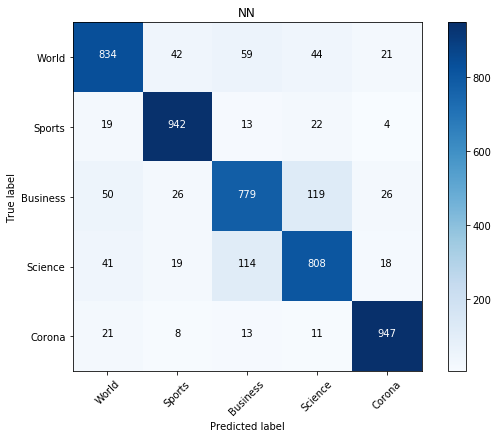

In [36]:
nn_cm = confusion_matrix(test_y, predictions.argmax(axis=1)+1)
cmPlotLabels = ['World', 'Sports', 'Business', 'Science', 'Corona']
plot_confusion_matrix(nn_cm, cmPlotLabels, title='NN')

In [23]:
nn_model.save("nn_w2v_google")